In [1]:
import pandas as pd
import cudf
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
import seaborn as sns 
import xgboost
import mlflow
from sklearn.model_selection import train_test_split
# from cuml.model_selection import train_test_split


In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [3]:
import cudf, cuml, cupy
# from cuml.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
from sklearn.svm import SVC

In [5]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
mlflow.autolog()

2023/01/17 21:30:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/01/17 21:30:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/01/17 21:30:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [7]:
plot_params = {
    'font.family': 'Ubuntu',
    'font.weight': 'light',
    
    'figure.figsize': (15,5),
    'figure.frameon': False, 
    'figure.titlesize': 'xx-large',
    'figure.titleweight': 'normal',
    
    'axes.titlesize': 'x-large',
    'axes.titlecolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlelocation': 'center',
    'axes.labelsize': 'x-large',

    'grid.alpha': .25, 
    'legend.frameon':False,
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
}

In [8]:
pylab.rcParams.update(plot_params)
sns.set_palette('mako')

In [9]:
SEED = 1943
np.random.seed(SEED)

In [10]:
os.listdir('data')

['Lyrics-Genre-Test-GroundTruth.csv', 'Lyrics-Genre-Train.csv']

In [11]:
TRAIN_PATH = 'data/Lyrics-Genre-Train.csv'
TEST_PATH = 'data/Lyrics-Genre-Test-GroundTruth.csv'

In [12]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

#### EDA

In [23]:
train_data.shape

(18513, 6)

In [24]:
train_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260


In [25]:
test_data.shape

(7935, 6)

In [26]:
test_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797


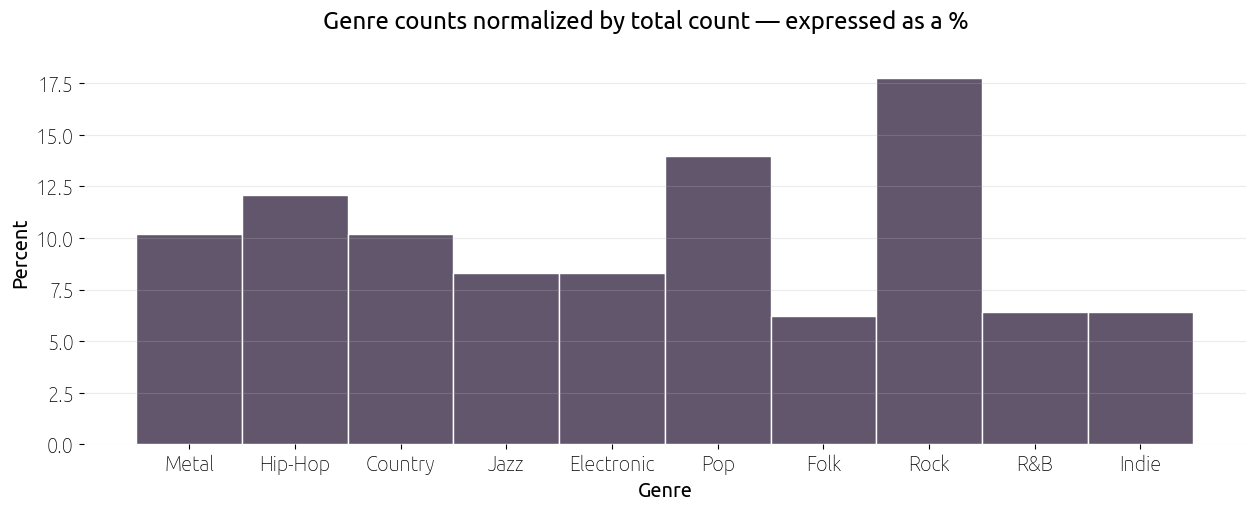

In [286]:
sns.histplot(train_data['Genre'], edgecolor = 'white', stat = 'percent')
plt.box(False)
plt.suptitle('Genre counts normalized by total count \u2015 expressed as a %')
plt.grid(axis = 'y')
plt.show()


In [28]:
train_data['Genre'].nunique()

10

There are 10 classes. A somewhat unbalanced dataset. Three classes with less than 5% samples. The majority class being Rock w/ approximately 18% of the entries.

In [43]:
pd.options.display.max_colwidth = 150

Checking samples.

In [48]:
train_data.groupby('Genre').head(5).sort_values(by = 'Genre')[['Genre','Lyrics']]

,Genre,Lyrics
49,Country,Ashes of love cold as ice you made the debt I'll pay the price\nOur love is gone there's no doubt ashes of love the flames burned out\nThe love li...
42,Country,"Well I married me a wife\nShe gave me trouble all my life\nShe ran me out in the cold rain and snow\nRain and snow, rain and snow\nShe ran me out ..."
30,Country,Your hunger after money\nYour parents agree\nThe things you don't require\nYou kid yourself you need\nNeglect the flower of love\nGive your worshi...
4,Country,"There ain't nothing that I would rather see\nThan you drying off on this dock\nI've been thinking, it's so good to be me\nBut girl, on second thou..."
15,Country,"I stay out late most every night until closing time\nTryin' to find a way to drink your mem'ry off my mind\nAnd even if it goes just right, I'd ne..."
32,Electronic,ounce for ounce\nblood for blood\nyou get a taste\nand it's never enough\npound for pound\neye for an eye\nyou get the thirst\nand it never runs d...
14,Electronic,"Every time I leave you, girl\nHe's the one that's near you, girl, oh I\nEven as I drive away\nI can hear the words he'll say, oh I\nI guess I don'..."
12,Electronic,Rock your body\nFeel the flow\nMind machine flashing\nThe green light to go\nBeat box drummer\nAnd a microphone\nThat's all we need to\nMake the s...
20,Electronic,"We got the green to the paper\nAnd enough green in the face, yeah\nJump up, put ya hand in the party\nJump up, 4:30 in the morning\nI'm gone when ..."
8,Electronic,"Well, don't get on the wrong train\nDon't fly in an old plane\nDon't go out in the p0uring rain\nYou might get wet I'd be upset\nYou're bound to g..."


Newline counts --- Basically the verses --- Also, possible lengths

In [56]:
subset = train_data[[ 'Genre', 'Lyrics']]

In [57]:
subset['newlines'] = subset['Lyrics'].str.count('\n')

/tmp/ipykernel_288300/3103477309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['newlines'] = subset['Lyrics'].str.count('\n')


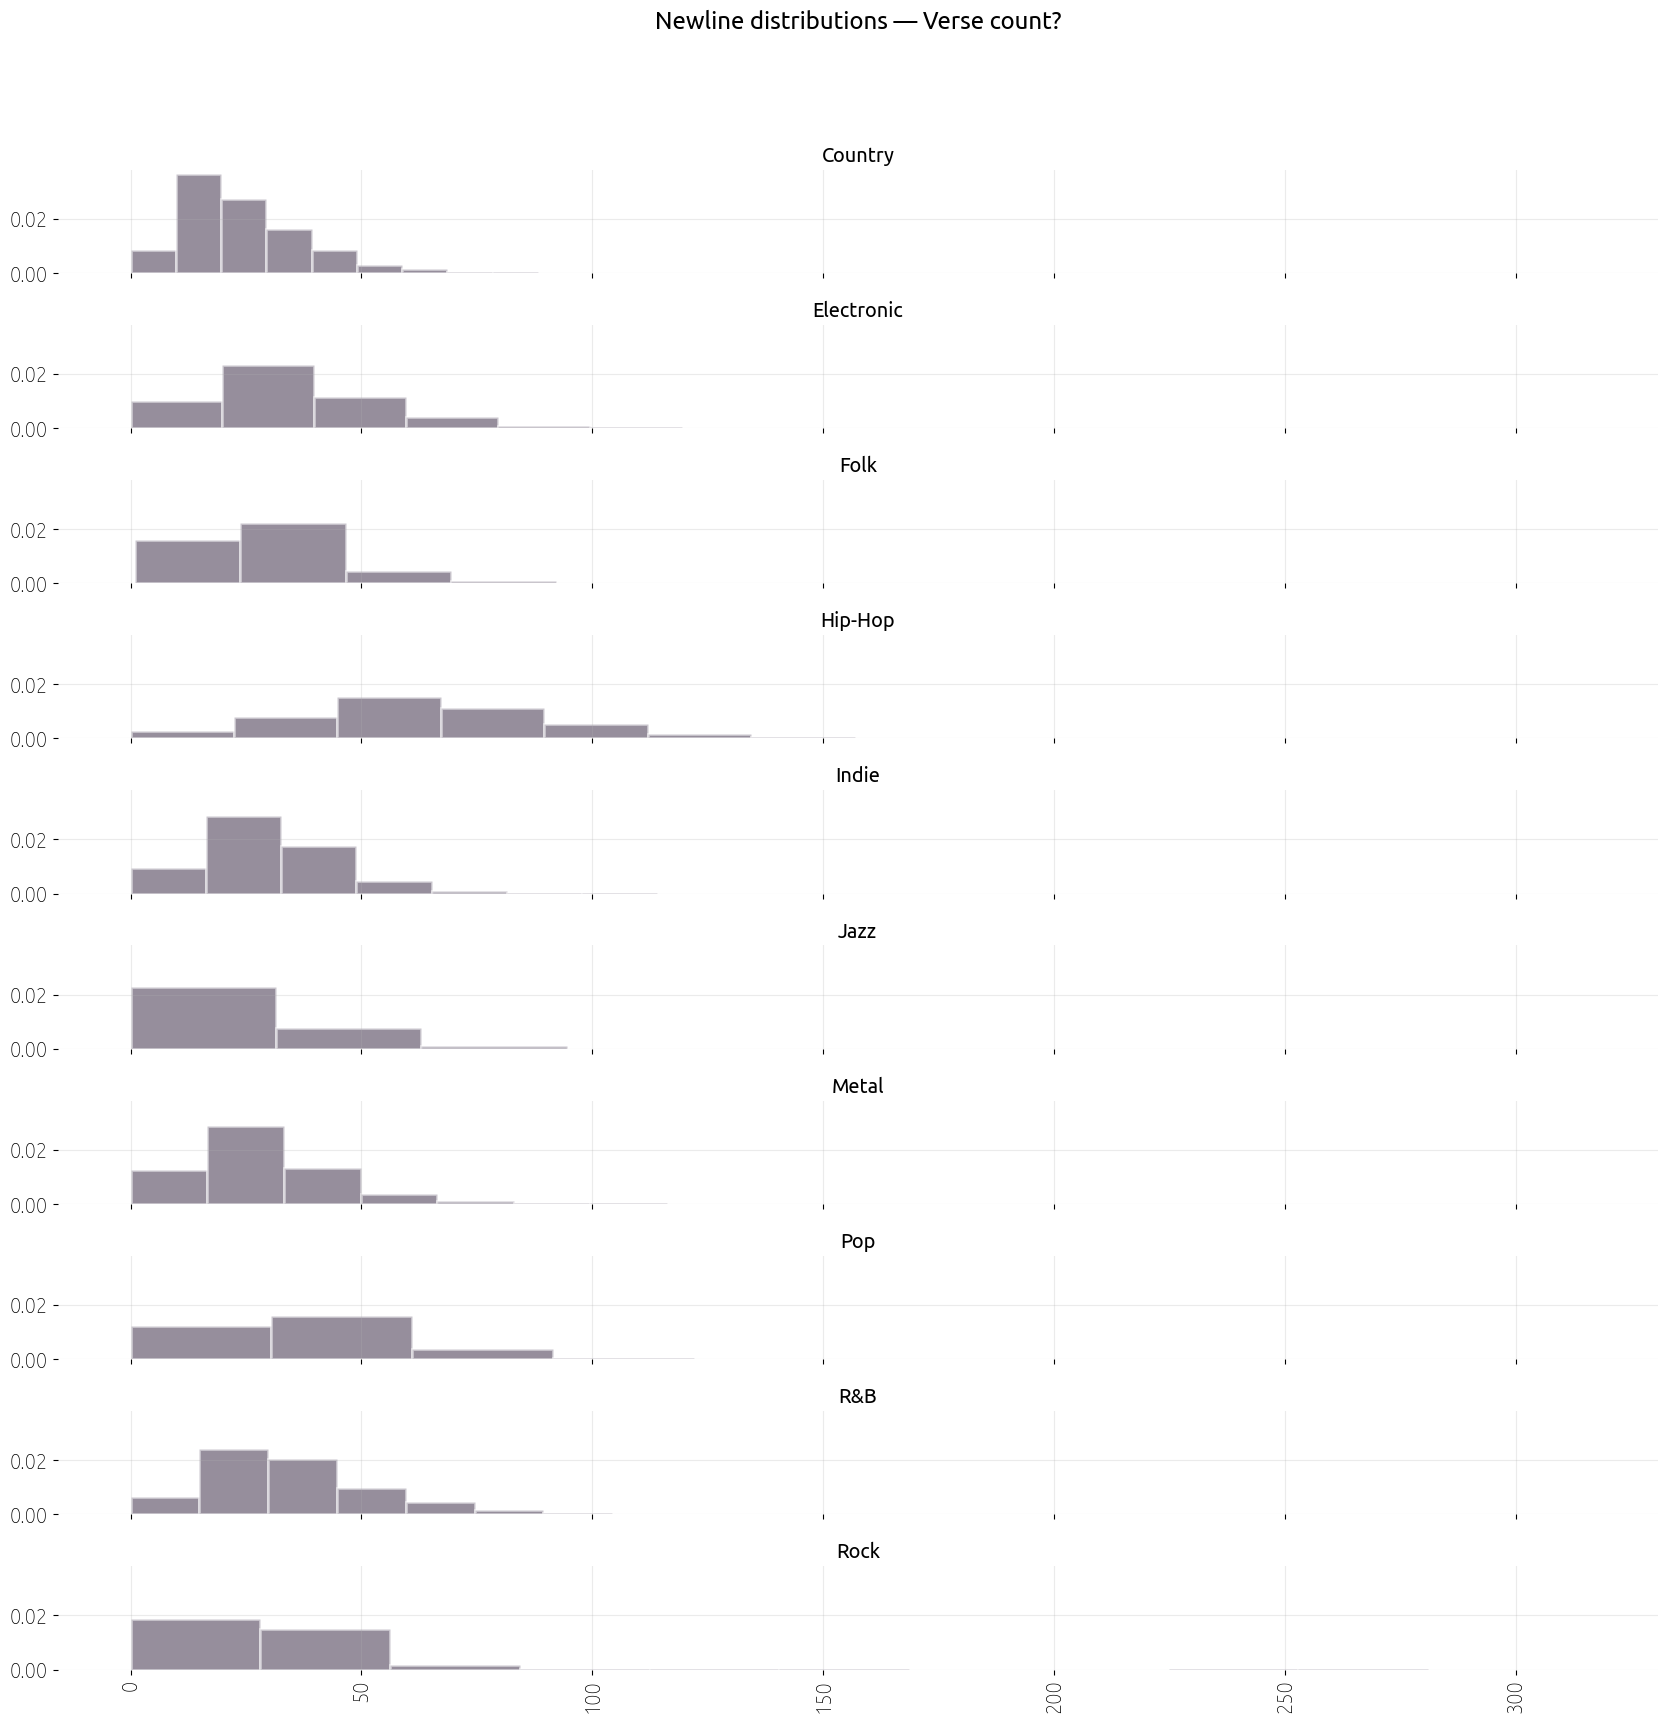

In [107]:
fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
subset['newlines'].hist(by = subset['Genre'], legend = False, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True, ax = axs)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.grid(.25)
fig.suptitle("Newline distributions \u2014 Verse count?")

plt.show()

What about the average verse length?

In [108]:
subset['verses'] = subset['Lyrics'].str.split('\n')

/tmp/ipykernel_288300/407760592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['verses'] = subset['Lyrics'].str.split('\n')


In [114]:
subset

,Genre,Lyrics,newlines,verses
0,Metal,"I am a night in to the darkness, only soul lost with me, I walk throught the\nnight in to the forest and everything stays behind me, i`m waiting f...",9,"[I am a night in to the darkness, only soul lost with me, I walk throught the, night in to the forest and everything stays behind me, i`m waiting ..."
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey say i can't.\nI can't skate, i can't surf. I ain't from the streets the beach is my turf.\nI can't s...",18,"[Yeah, Sometimes, i just wanna fly away., They say i can't., I can't skate, i can't surf. I ain't from the streets the beach is my turf., I can't ..."
2,Metal,"Do you work hard?\nDo you work hard?\nYou don't!\nYou don't!\nYou don't! Chicago, now!\nDo you work hard?\nDo you try hard?\nYou don't. Chicago, n...",28,"[Do you work hard?, Do you work hard?, You don't!, You don't!, You don't! Chicago, now!, Do you work hard?, Do you try hard?, You don't. Chicago, ..."
3,Hip-Hop,"You know what? I'm destined to be the last man standin\nCarefully mappin my escape through plannin\nCome in and get it, and leave here with it\nMa...",53,"[You know what? I'm destined to be the last man standin, Carefully mappin my escape through plannin, Come in and get it, and leave here with it, M..."
4,Country,"There ain't nothing that I would rather see\nThan you drying off on this dock\nI've been thinking, it's so good to be me\nBut girl, on second thou...",24,"[There ain't nothing that I would rather see, Than you drying off on this dock, I've been thinking, it's so good to be me, But girl, on second tho..."
...,...,...,...,...
18508,R&B,I'm the best friend he's got\nI'd give him the shirt off my back\nHe knows he can trust me with his life\nBut he's tryin' to leave me alone\nLeave...,46,"[I'm the best friend he's got, I'd give him the shirt off my back, He knows he can trust me with his life, But he's tryin' to leave me alone, Leav..."
18509,Pop,"Bad Boys Blue\n""I Totally Miss You""\nI did you wrong,\nMy foolish heart went out to play.\nAnd then I lost you,\nOh What a price for me to pay.\nW...",47,"[Bad Boys Blue, ""I Totally Miss You"", I did you wrong,, My foolish heart went out to play., And then I lost you,, Oh What a price for me to pay., ..."
18510,Pop,"Forgive me for the things\nThat I never said to you\nForgive me for not knowing\nThe right words to say, to prove\nThat I will always be\nDevoted ...",55,"[Forgive me for the things, That I never said to you, Forgive me for not knowing, The right words to say, to prove, That I will always be, Devoted..."
18511,Indie,The day they found a cure for AIDS\nThe day they found a cure for AIDS\nEverybody took one little pill and was okay\nThe day they found a cure\nTh...,23,"[The day they found a cure for AIDS, The day they found a cure for AIDS, Everybody took one little pill and was okay, The day they found a cure, T..."


In [132]:
def get_mean_verse_length(verses):
    return np.mean([len(verse) for verse in verses], dtype = np.float16)

In [133]:
subset['mean_verse_length'] = subset.verses.map(get_mean_verse_length)

/tmp/ipykernel_288300/2089163761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['mean_verse_length'] = subset.verses.map(get_mean_verse_length)


In [134]:
subset

,Genre,Lyrics,newlines,verses,mean_verse_length
0,Metal,"I am a night in to the darkness, only soul lost with me, I walk throught the\nnight in to the forest and everything stays behind me, i`m waiting f...",9,"[I am a night in to the darkness, only soul lost with me, I walk throught the, night in to the forest and everything stays behind me, i`m waiting ...",62.406250
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey say i can't.\nI can't skate, i can't surf. I ain't from the streets the beach is my turf.\nI can't s...",18,"[Yeah, Sometimes, i just wanna fly away., They say i can't., I can't skate, i can't surf. I ain't from the streets the beach is my turf., I can't ...",115.562500
2,Metal,"Do you work hard?\nDo you work hard?\nYou don't!\nYou don't!\nYou don't! Chicago, now!\nDo you work hard?\nDo you try hard?\nYou don't. Chicago, n...",28,"[Do you work hard?, Do you work hard?, You don't!, You don't!, You don't! Chicago, now!, Do you work hard?, Do you try hard?, You don't. Chicago, ...",17.171875
3,Hip-Hop,"You know what? I'm destined to be the last man standin\nCarefully mappin my escape through plannin\nCome in and get it, and leave here with it\nMa...",53,"[You know what? I'm destined to be the last man standin, Carefully mappin my escape through plannin, Come in and get it, and leave here with it, M...",43.875000
4,Country,"There ain't nothing that I would rather see\nThan you drying off on this dock\nI've been thinking, it's so good to be me\nBut girl, on second thou...",24,"[There ain't nothing that I would rather see, Than you drying off on this dock, I've been thinking, it's so good to be me, But girl, on second tho...",41.562500
...,...,...,...,...,...
18508,R&B,I'm the best friend he's got\nI'd give him the shirt off my back\nHe knows he can trust me with his life\nBut he's tryin' to leave me alone\nLeave...,46,"[I'm the best friend he's got, I'd give him the shirt off my back, He knows he can trust me with his life, But he's tryin' to leave me alone, Leav...",30.875000
18509,Pop,"Bad Boys Blue\n""I Totally Miss You""\nI did you wrong,\nMy foolish heart went out to play.\nAnd then I lost you,\nOh What a price for me to pay.\nW...",47,"[Bad Boys Blue, ""I Totally Miss You"", I did you wrong,, My foolish heart went out to play., And then I lost you,, Oh What a price for me to pay., ...",26.609375
18510,Pop,"Forgive me for the things\nThat I never said to you\nForgive me for not knowing\nThe right words to say, to prove\nThat I will always be\nDevoted ...",55,"[Forgive me for the things, That I never said to you, Forgive me for not knowing, The right words to say, to prove, That I will always be, Devoted...",23.734375
18511,Indie,The day they found a cure for AIDS\nThe day they found a cure for AIDS\nEverybody took one little pill and was okay\nThe day they found a cure\nTh...,23,"[The day they found a cure for AIDS, The day they found a cure for AIDS, Everybody took one little pill and was okay, The day they found a cure, T...",40.531250


In [141]:
subset.Genre.unique().tolist()

['Metal',
 'Hip-Hop',
 'Country',
 'Jazz',
 'Electronic',
 'Pop',
 'Folk',
 'Rock',
 'R&B',
 'Indie']

In [147]:
subset.loc[(subset.Genre == 'Metal')]

,Genre,Lyrics,newlines,verses,mean_verse_length
0,Metal,"I am a night in to the darkness, only soul lost with me, I walk throught the\nnight in to the forest and everything stays behind me, i`m waiting f...",9,"[I am a night in to the darkness, only soul lost with me, I walk throught the, night in to the forest and everything stays behind me, i`m waiting ...",62.406250
2,Metal,"Do you work hard?\nDo you work hard?\nYou don't!\nYou don't!\nYou don't! Chicago, now!\nDo you work hard?\nDo you try hard?\nYou don't. Chicago, n...",28,"[Do you work hard?, Do you work hard?, You don't!, You don't!, You don't! Chicago, now!, Do you work hard?, Do you try hard?, You don't. Chicago, ...",17.171875
11,Metal,I'm a sacred king in a sacred kingdom\nYou know me just as a royality\nLooking kind so you don't see\nI'd like to steal your virginity\nI was born...,42,"[I'm a sacred king in a sacred kingdom, You know me just as a royality, Looking kind so you don't see, I'd like to steal your virginity, I was bor...",29.812500
17,Metal,Deep into the darkness peering\nLong I stood there fearing\nDreaming dreams no mortal ever dared to dream before...\nBut the silence was unbroken\...,23,"[Deep into the darkness peering, Long I stood there fearing, Dreaming dreams no mortal ever dared to dream before..., But the silence was unbroken...",32.531250
19,Metal,Lying awake in the dead of night\nListening to my heart beat away\nWishing I wasn't alone here tonight\nBut wishing just gets in the way\nI just w...,16,"[Lying awake in the dead of night, Listening to my heart beat away, Wishing I wasn't alone here tonight, But wishing just gets in the way, I just ...",33.718750
...,...,...,...,...,...
18447,Metal,"Wrong, all that we are\nLiving, breathing lies\nWrong, all that I feel\nAll compassion dies\n[Chorus:]\nOnce hand in hand\nAnd now detached\nBefri...",34,"[Wrong, all that we are, Living, breathing lies, Wrong, all that I feel, All compassion dies, [Chorus:], Once hand in hand, And now detached, Befr...",22.234375
18460,Metal,To much of this force!\nThe lack of structure!\nMy life burnt\nReflecting a forest in flames!\nTime withdraws\nHard times ahead\nThe rules are bro...,30,"[To much of this force!, The lack of structure!, My life burnt, Reflecting a forest in flames!, Time withdraws, Hard times ahead, The rules are br...",20.093750
18488,Metal,[1.]\nI am the one that makes you weak\nI am the one that makes you feel like a spineless creep\nI am the one without no heart\nI am the one that ...,33,"[[1.], I am the one that makes you weak, I am the one that makes you feel like a spineless creep, I am the one without no heart, I am the one that...",25.296875
18495,Metal,I used to be blind\nLiving inside a dream someone had created\nWithout knowing where I really was\nSearching my mind for the answer\nMy hands was ...,28,"[I used to be blind, Living inside a dream someone had created, Without knowing where I really was, Searching my mind for the answer, My hands was...",32.062500


In [162]:
subset.loc[(subset.Genre == 'Metal')]['mean_verse_length'].reset_index(drop=True)

0       62.406250
1       17.171875
2       29.812500
3       32.531250
4       33.718750
          ...    
1885    22.234375
1886    20.093750
1887    25.296875
1888    32.062500
1889    36.156250
Name: mean_verse_length, Length: 1890, dtype: float16

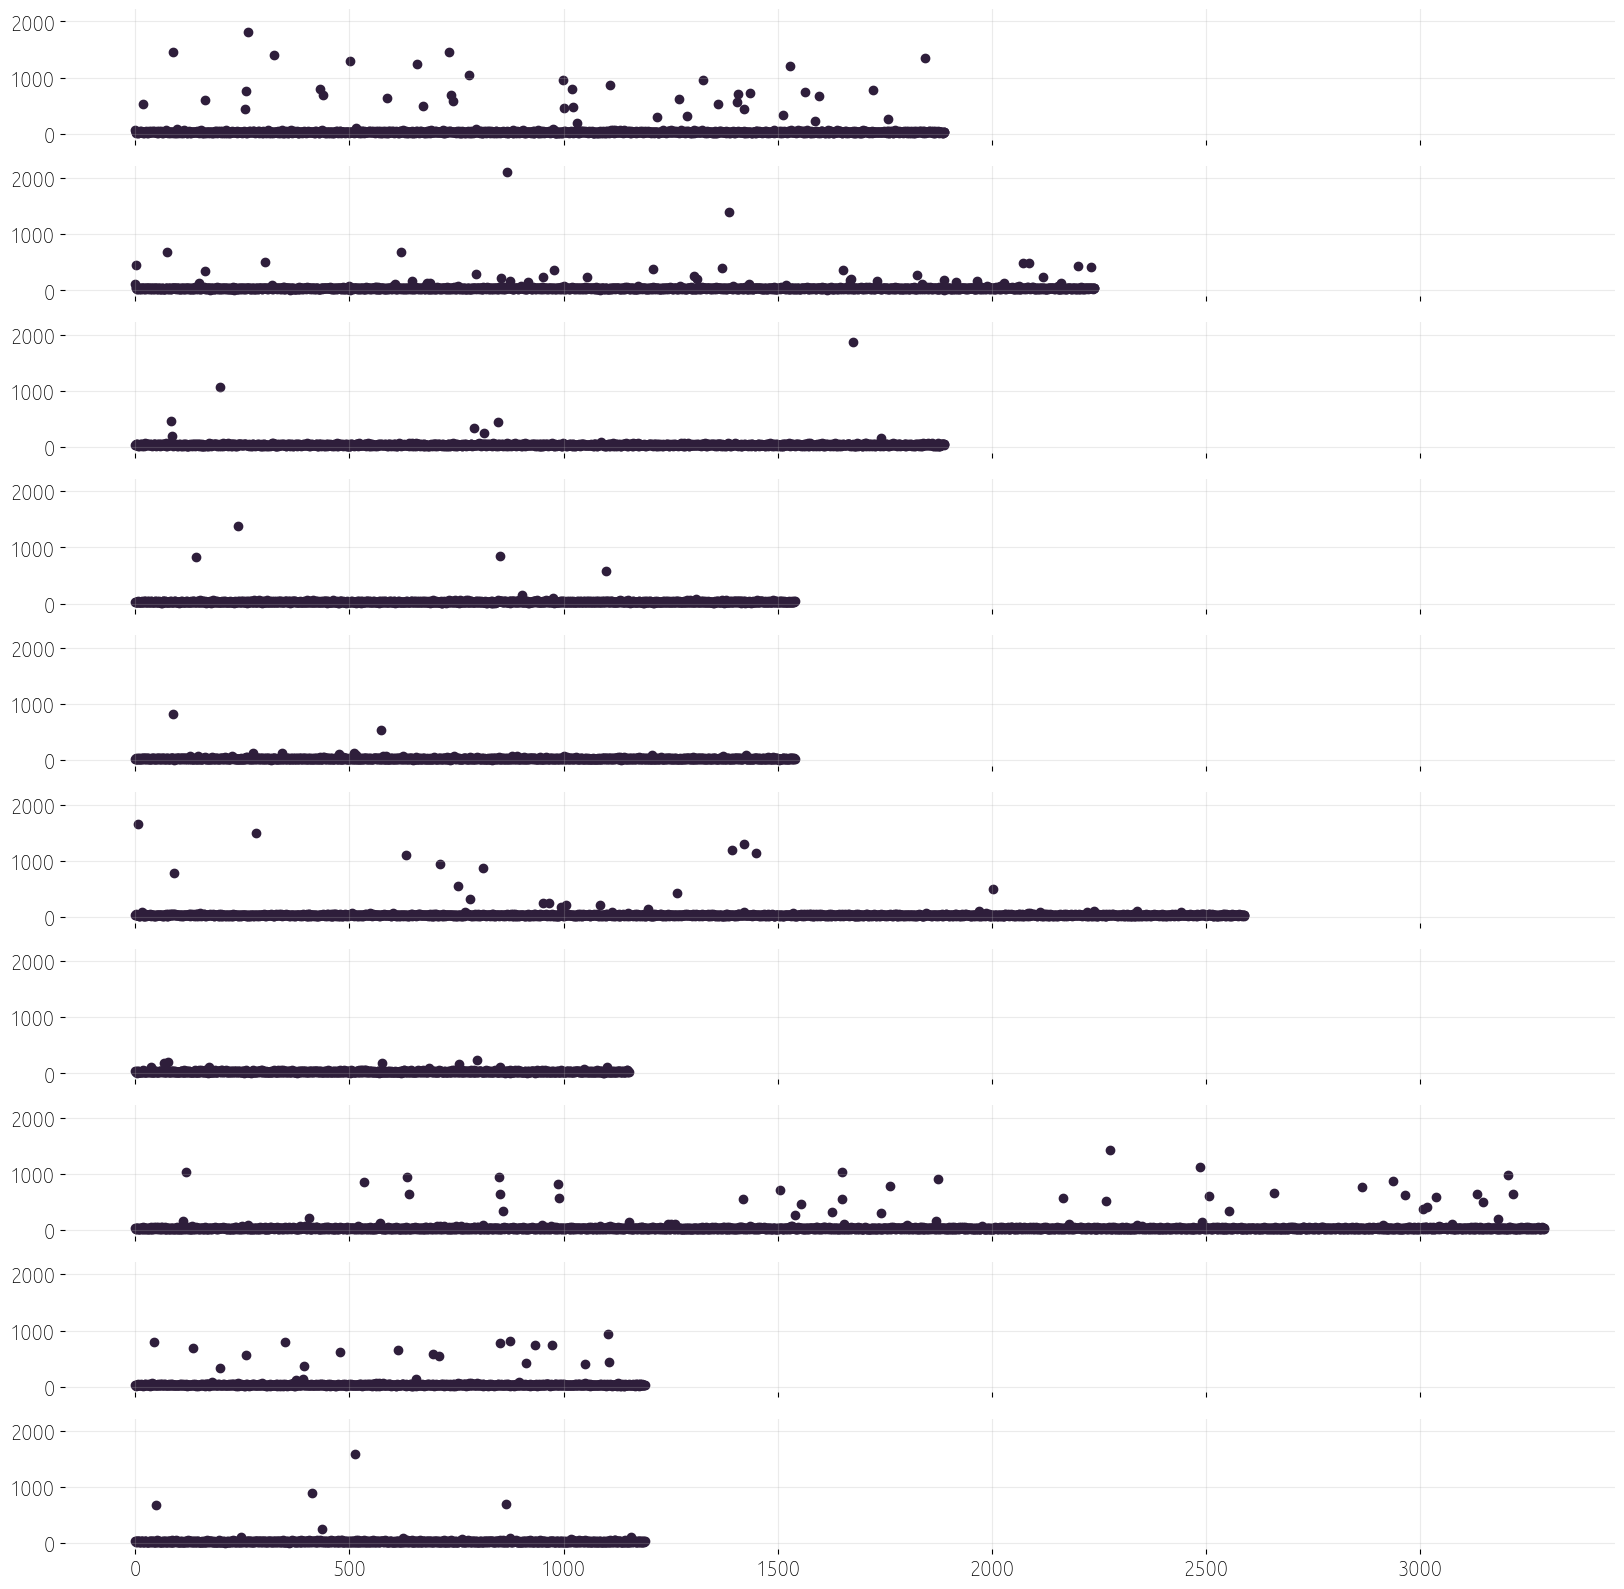

In [163]:

fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
axs_idx = 0
axs = axs.flatten()
for genre in subset.Genre.unique().tolist():

    subs = subset.loc[(subset.Genre == genre)]['mean_verse_length'].reset_index(drop=True)
    axs[axs_idx].scatter(subs.index, subs.values)
    axs[axs_idx].set_frame_on(False)
    axs[axs_idx].grid(.25)
    axs_idx += 1
plt.show()

In [169]:
subset.loc[(subset.mean_verse_length > 100)]

,Genre,Lyrics,newlines,verses,mean_verse_length
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey say i can't.\nI can't skate, i can't surf. I ain't from the streets the beach is my turf.\nI can't s...",18,"[Yeah, Sometimes, i just wanna fly away., They say i can't., I can't skate, i can't surf. I ain't from the streets the beach is my turf., I can't ...",115.5625
5,Hip-Hop,"(Mr. Gene Poole)\nLovin' this sound comin out to yo system\nI spark to get yall off to a good start. Show me some heart, walk through my hood afte...",6,"[(Mr. Gene Poole), Lovin' this sound comin out to yo system, I spark to get yall off to a good start. Show me some heart, walk through my hood aft...",458.2500
61,Pop,Maybe it's time to compromise Stop moving your mouth and use your eyes But I don't think so You think you know what people like Why don't you try ...,0,[Maybe it's time to compromise Stop moving your mouth and use your eyes But I don't think so You think you know what people like Why don't you try...,1648.0000
227,Metal,for all the thousands i've killed for all the children i've tortured for all the souls i've burned hear a demons cry you carved into me the darken...,0,[for all the thousands i've killed for all the children i've tortured for all the souls i've burned hear a demons cry you carved into me the darke...,522.0000
568,Folk,I thought you were the only one that I'd ever see. But you weren't the one to show me what it meant to believe.\nI thought that we had found a hom...,4,"[I thought you were the only one that I'd ever see. But you weren't the one to show me what it meant to believe., I thought that we had found a ho...",118.0000
...,...,...,...,...,...
18044,Indie,*Don't player hate on me. play- player hate on somebody else*\nYo. yo yo. I'm-i'm a gangster. where're my dogs at? bark with me if you're my dog.y...,18,"[*Don't player hate on me. play- player hate on somebody else*, Yo. yo yo. I'm-i'm a gangster. where're my dogs at? bark with me if you're my dog....",120.6250
18081,Rock,baby I don't practice sangria | maybe what he had was just green horn | every fucking day a thousand pools are being born | do you have the time t...,0,[baby I don't practice sangria | maybe what he had was just green horn | every fucking day a thousand pools are being born | do you have the time ...,975.0000
18152,Rock,"You're led to think we're free, a democratic race Told of equal rights well that's just not the case It couldn't happen to a democratic nation Afr...",0,"[You're led to think we're free, a democratic race Told of equal rights well that's just not the case It couldn't happen to a democratic nation Af...",640.0000
18178,Hip-Hop,"I was a dark dumb student, no hokey rookie daytrippin on visions of chickens that looked like R Crumb drew em. They grew em in the royal dirt of S...",7,"[I was a dark dumb student, no hokey rookie daytrippin on visions of chickens that looked like R Crumb drew em. They grew em in the royal dirt of ...",441.2500


Basically, relying on newline segmentation is not the best, but only ~200 samples have a mean verse length greater than 100. 

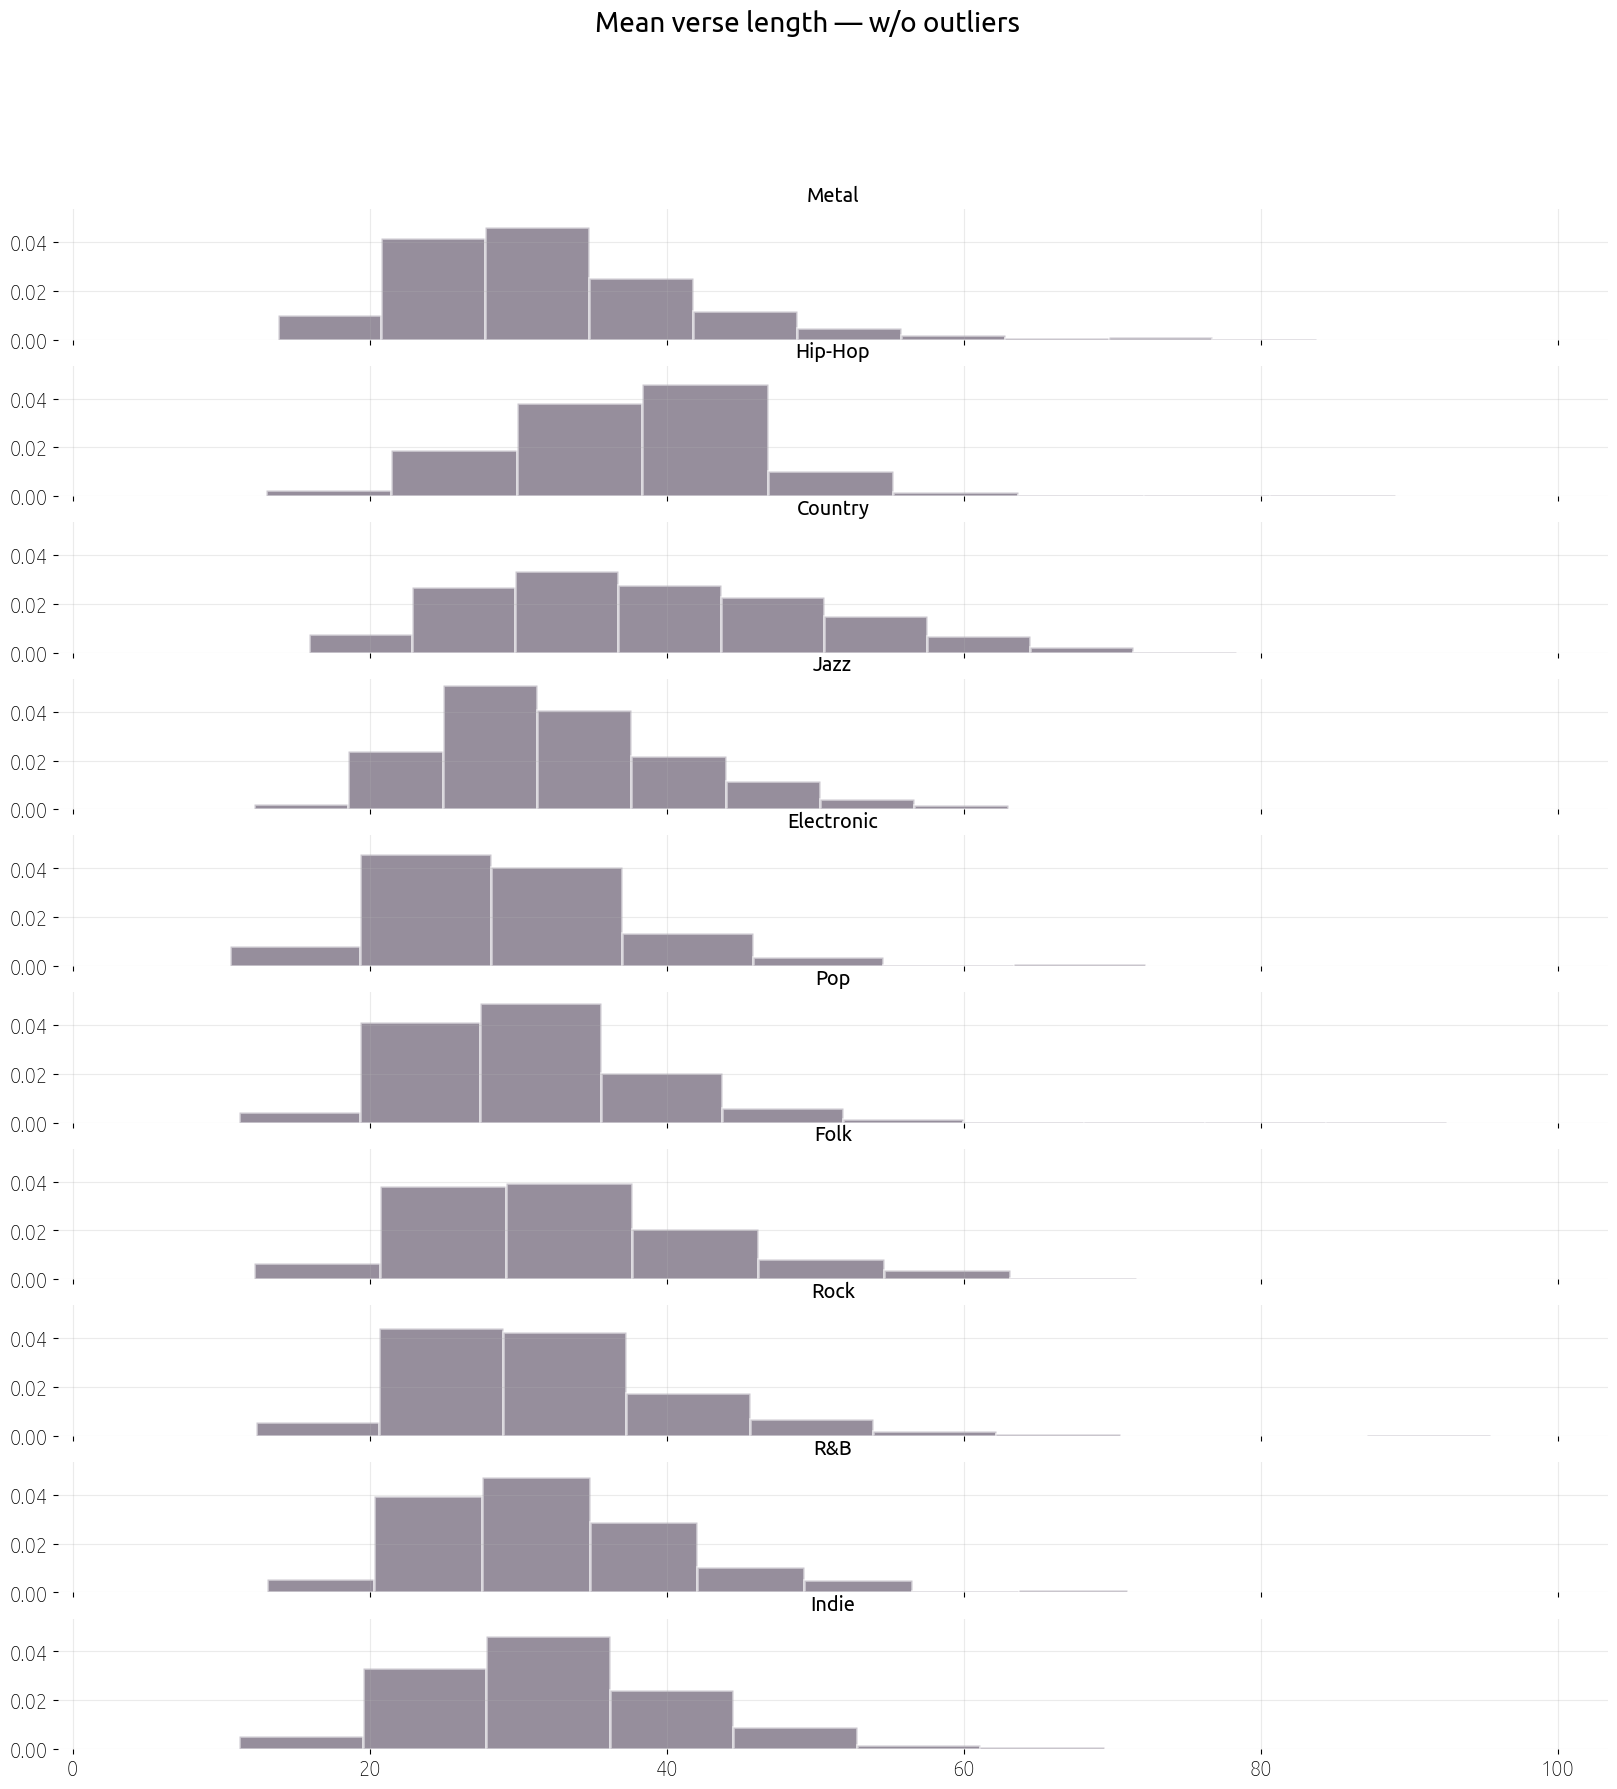

In [181]:

fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
axs_idx = 0
axs = axs.flatten()
for genre in subset.Genre.unique().tolist():

    subs = subset.loc[(subset.Genre == genre)].loc[(subset.mean_verse_length < 100)]['mean_verse_length'].reset_index(drop=True)

    axs[axs_idx].hist(subs, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True )
    axs[axs_idx].set_frame_on(False)
    axs[axs_idx].grid(.25)
    axs[axs_idx].set_title(genre)
    axs_idx += 1
plt.suptitle('Mean verse length \u2014 w/o outliers', fontsize = 20)
plt.show()


What about verse repetition?

In [191]:
subset['unique_verses'] = subset.verses.map(set)
subset['unique_verses_count'] = subset.unique_verses.map(len)

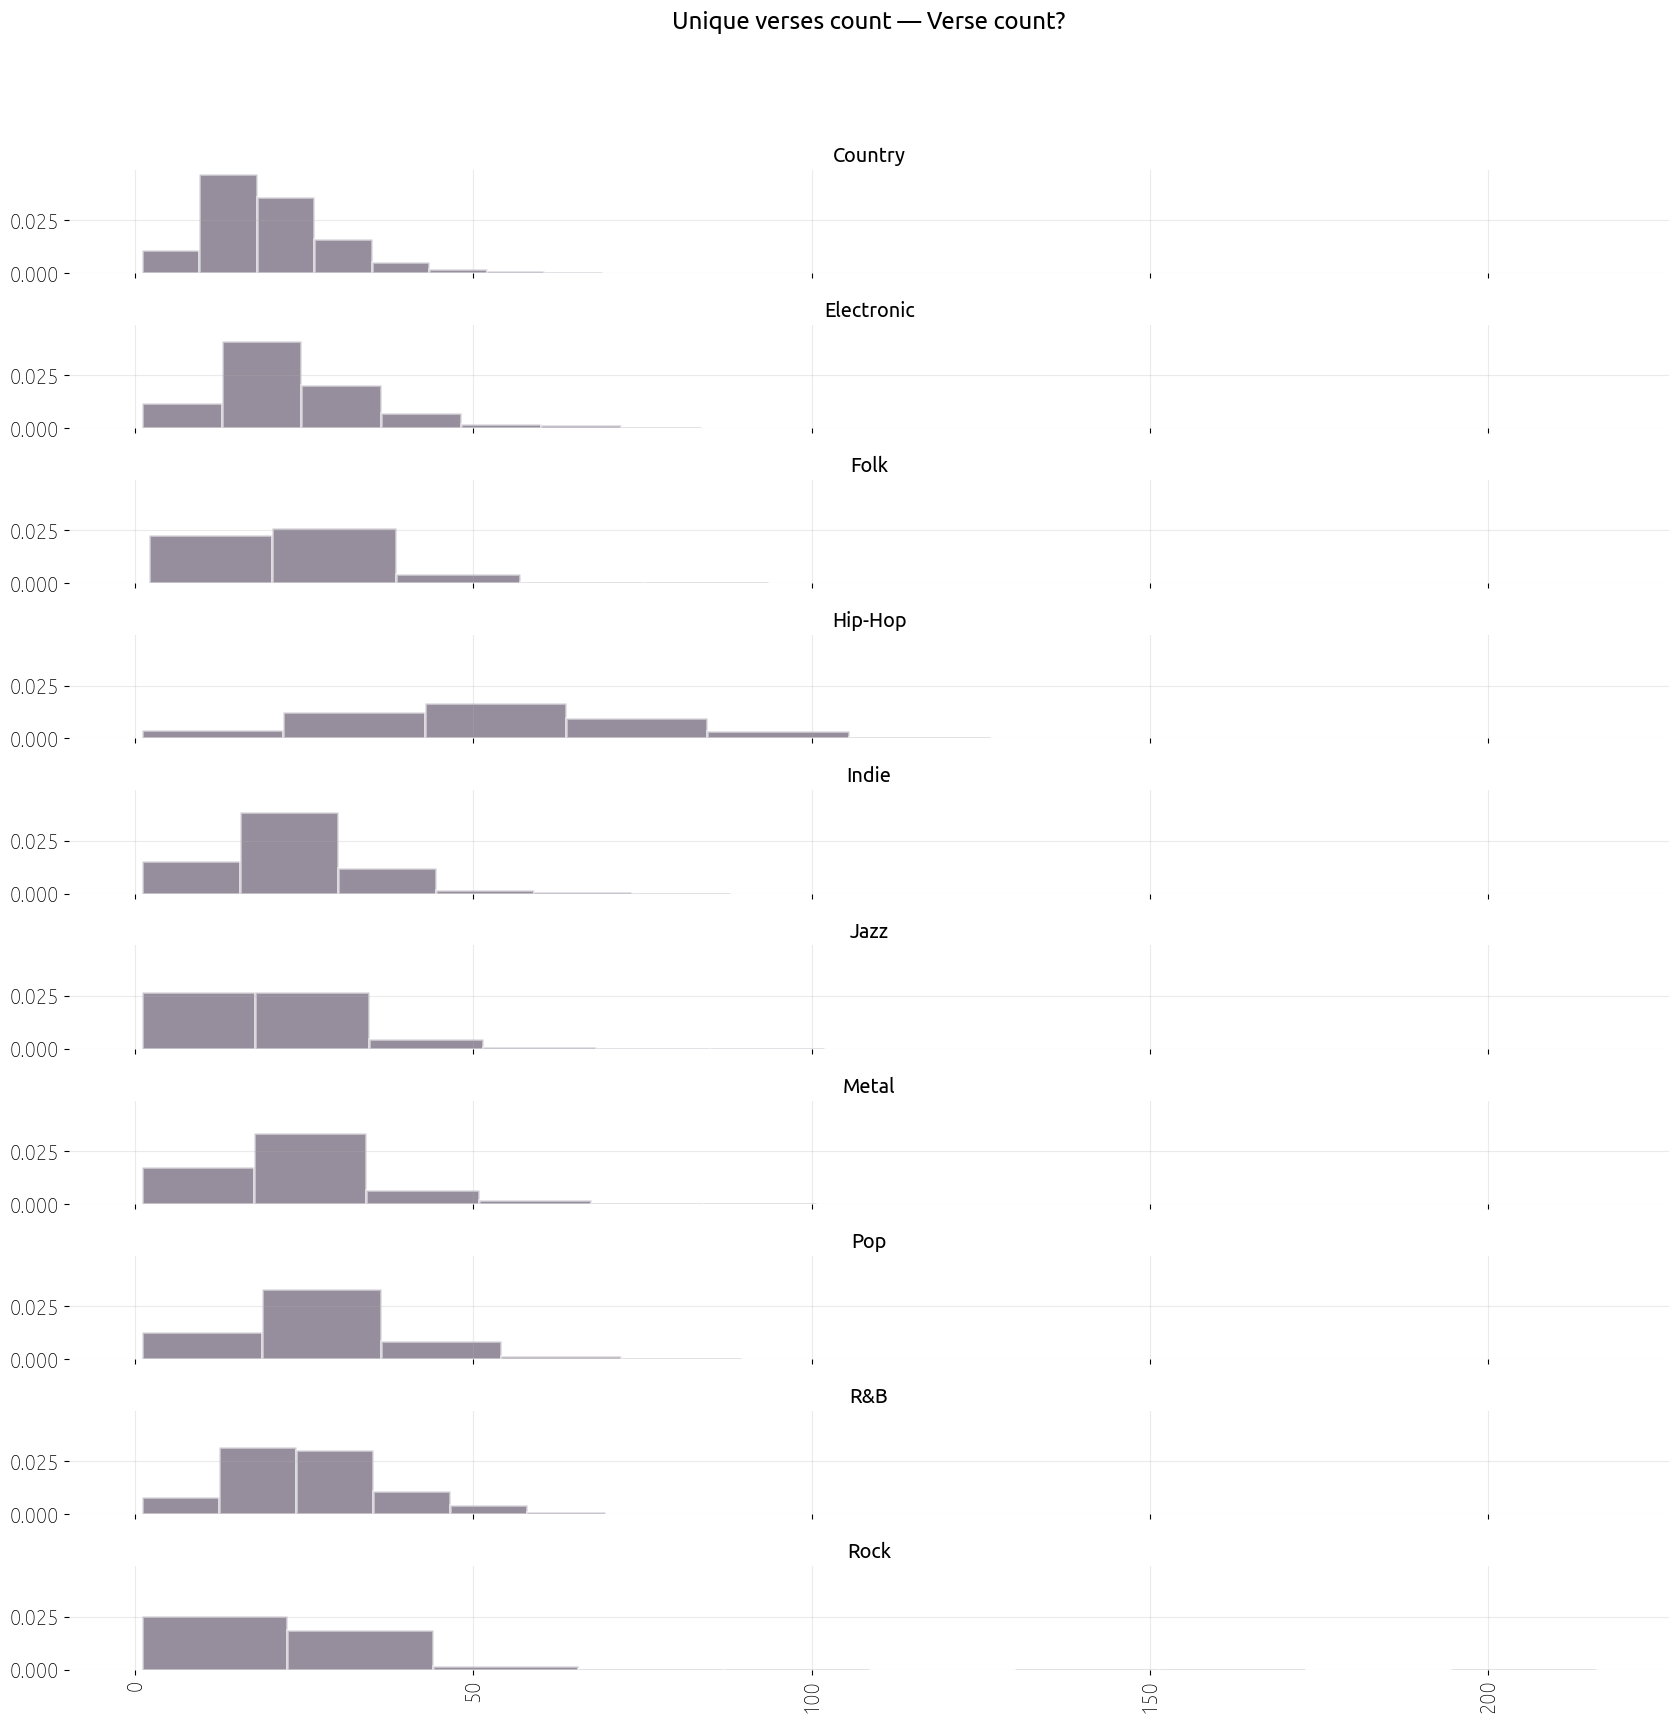

In [193]:
fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
subset['unique_verses_count'].hist(by = subset['Genre'], legend = False, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True, ax = axs)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.grid(.25)
fig.suptitle("Unique verses count \u2014 Verse count?")

plt.show()

In [187]:
# Difference between verses count and unique verses count
subset.verses.map(len) - subset.verses.map(set).map(len) 

0         0
1         4
2         8
3         1
4         8
         ..
18508    10
18509    22
18510    15
18511    10
18512     5
Name: verses, Length: 18513, dtype: int64

In [195]:
from collections import Counter

In [197]:
subset['verse_counts'] = subset.verses.map(Counter)

In [256]:
# Disregarding single verses
subset['filtered_verse_counts'] = subset.verse_counts.map(lambda counts: {x: count for x, count in counts.items() if count > 1})

In [258]:
subset['repeated_verses_num'] = subset.filtered_verse_counts.map(len)

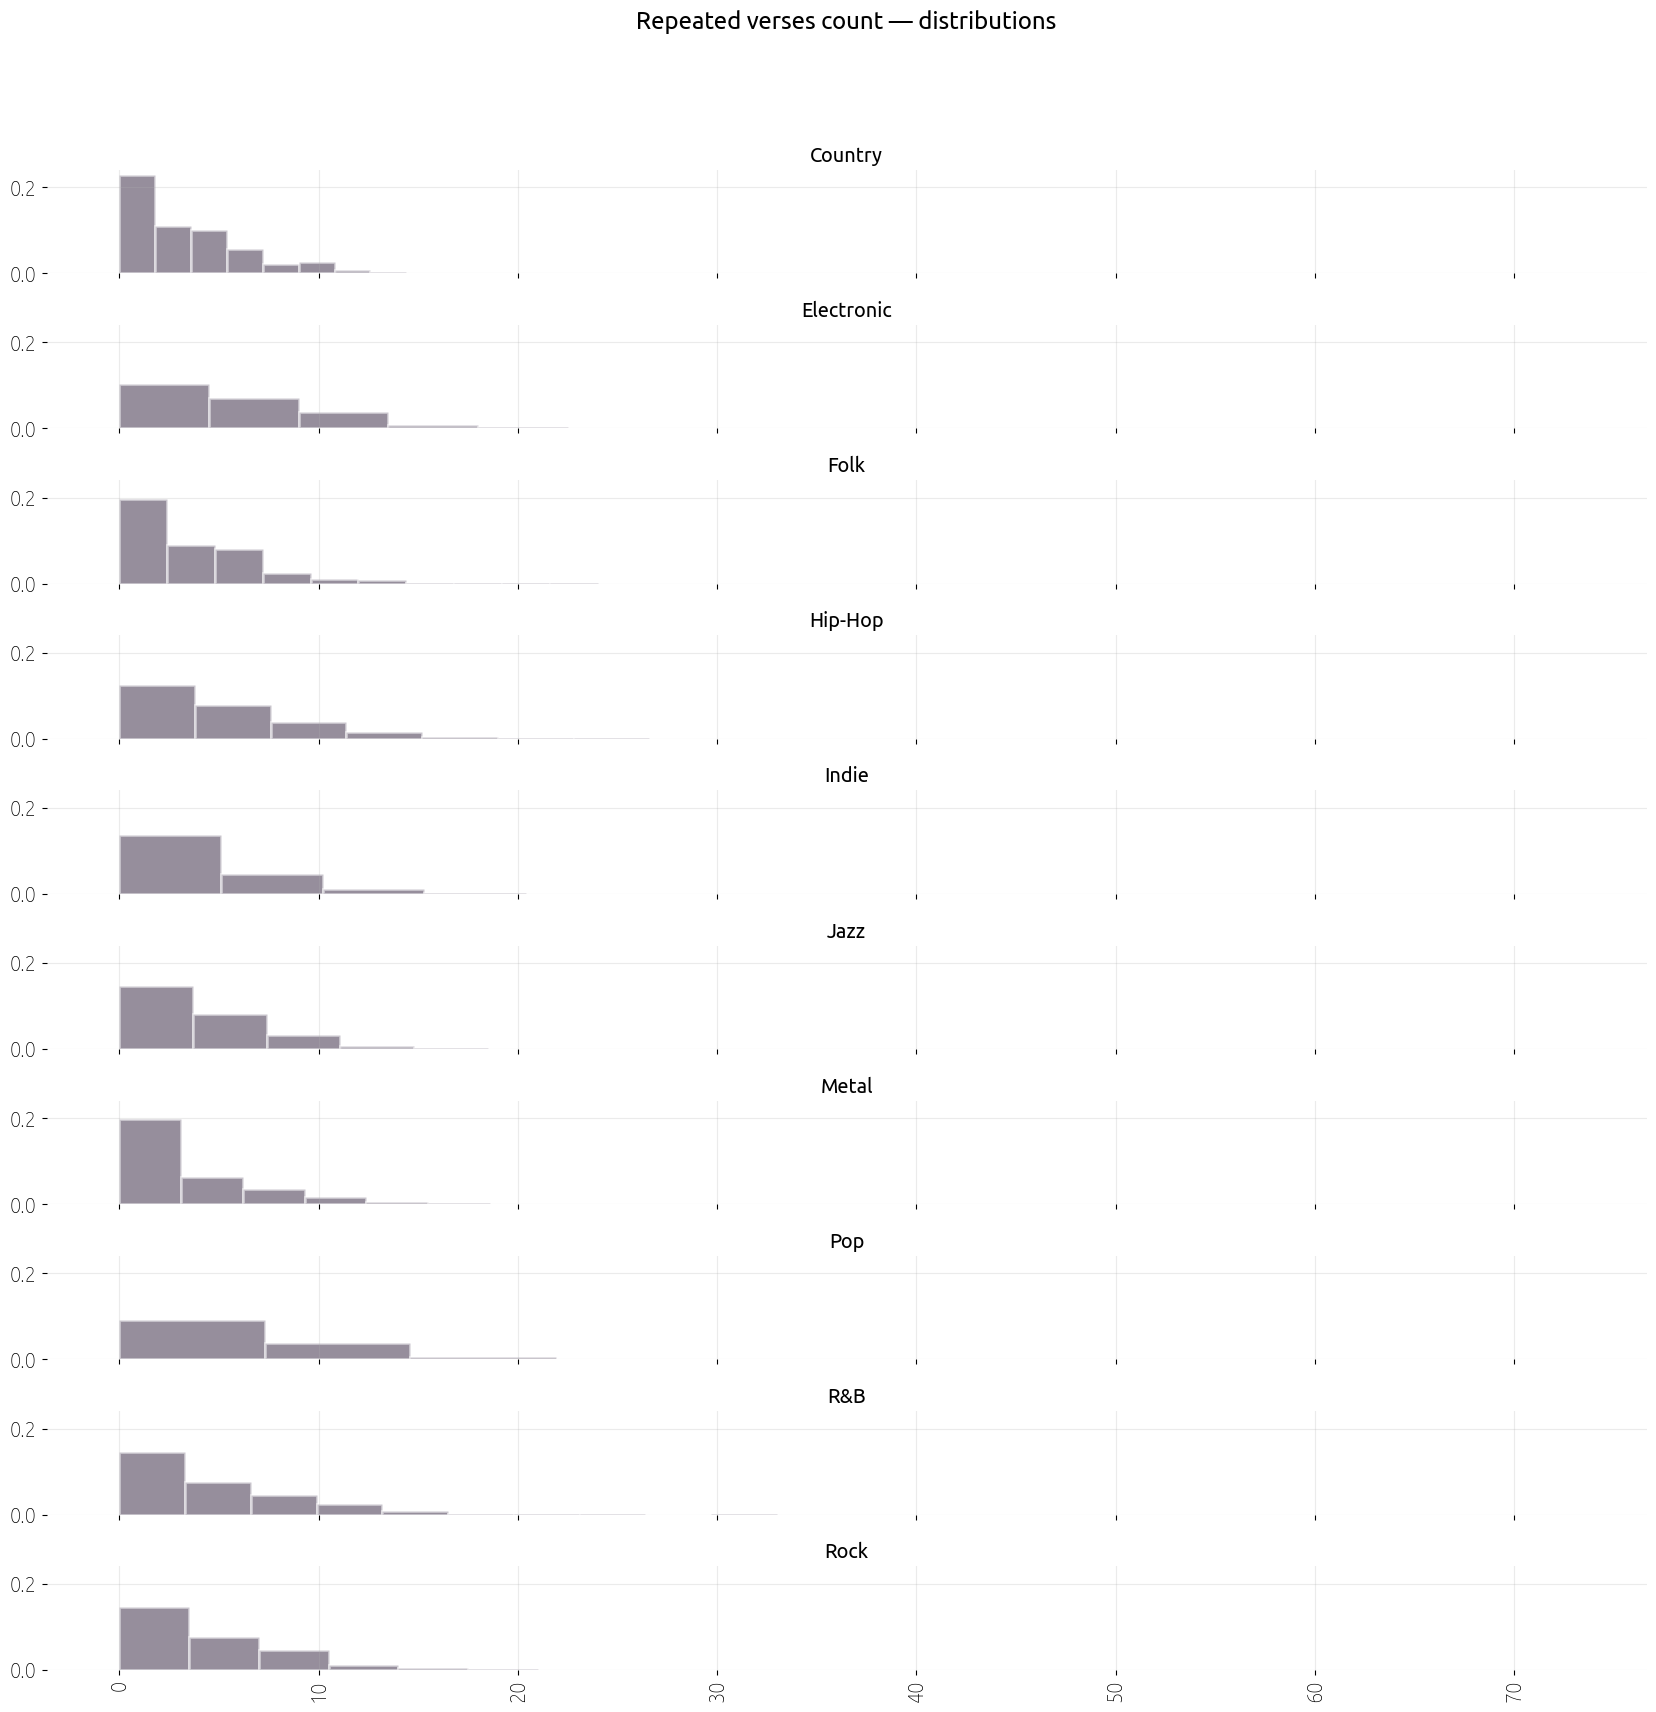

In [279]:
fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
subset['repeated_verses_num'].hist(by = subset['Genre'], legend = False, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True, ax = axs)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.grid(.25)
fig.suptitle("Repeated verses count \u2014 distributions")

plt.show()

In [269]:
subset['filtered_verse_counts_mean_repetition_count'] = subset['filtered_verse_counts'].apply(lambda x: np.mean(list(x.values()))).fillna(0)

/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


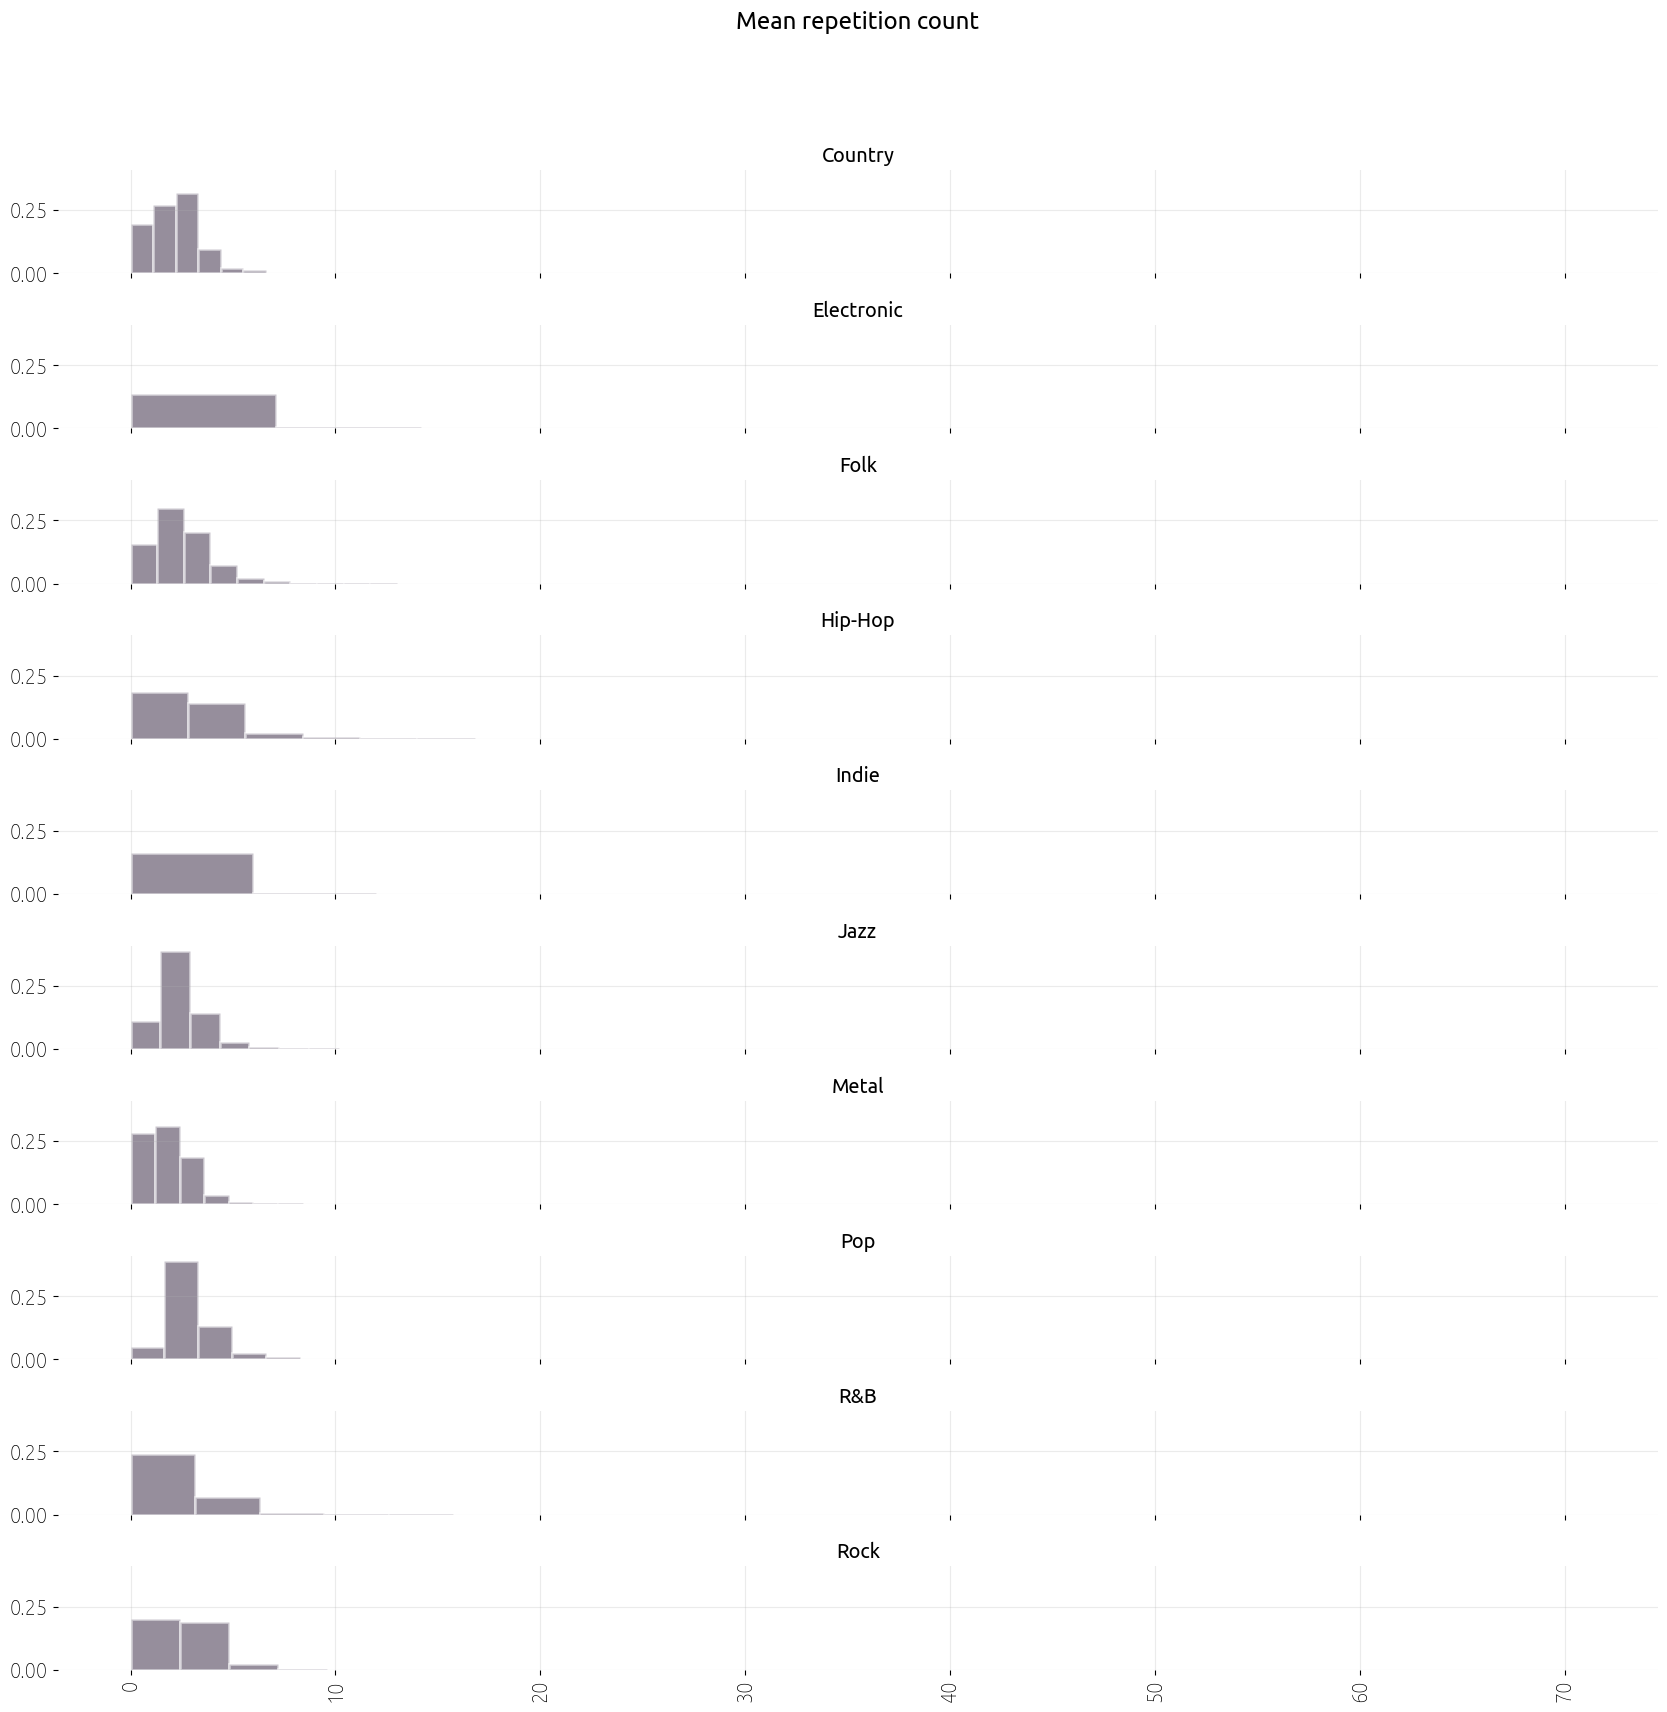

In [278]:
fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
subset['filtered_verse_counts_mean_repetition_count'].hist(by = subset['Genre'], bins = 10, legend = False, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True, ax = axs)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.grid(.25)
fig.suptitle("Mean repetition count")

plt.show()

Contains chorus

In [212]:
subset['contains_chorus'] = subset.Lyrics.str.contains('chorus', case = False)

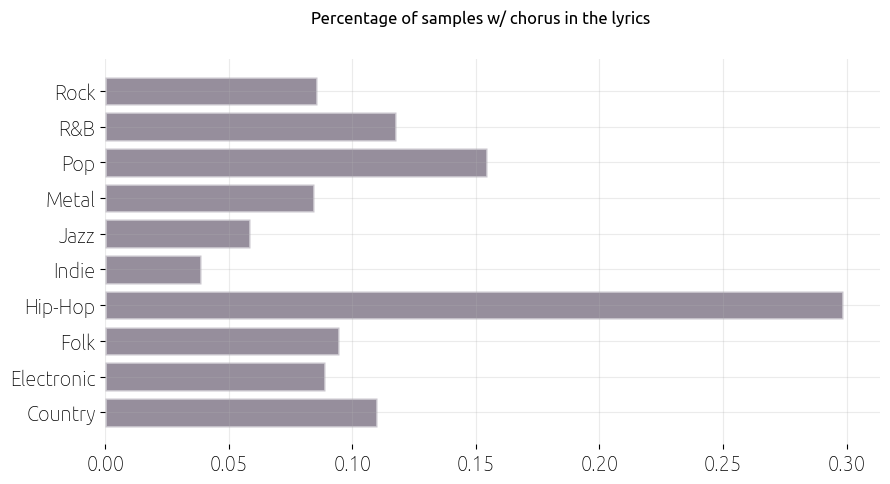

In [255]:
fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

chorus_true = subset.loc[subset['contains_chorus']].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(chorus_true.index, chorus_true.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ chorus in the lyrics', fontsize = 12)
plt.grid(.25)
plt.show()

#### Modeling

In [13]:
X_train, Y_train = train_data[['Lyrics']], train_data['Genre']

X_test, Y_test = test_data[['Lyrics']], test_data['Genre']

In [14]:
train_data

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260
...,...,...,...,...,...,...
18508,i-wish-he-didn-t-trust-me-so-much,2008,bobby-womack,R&B,I'm the best friend he's got\nI'd give him the...,12033
18509,i-totally-miss-you,2006,bad-boys-blue,Pop,"Bad Boys Blue\n""I Totally Miss You""\nI did you...",15987
18510,sorry-for-love,2002,celine-dion,Pop,Forgive me for the things\nThat I never said t...,2722
18511,cure-for-aids,2008,dan-bern,Indie,The day they found a cure for AIDS\nThe day th...,10221


In [15]:
X_train

,Lyrics
0,"I am a night in to the darkness, only soul los..."
1,"Yeah\nSometimes, i just wanna fly away.\nThey ..."
2,Do you work hard?\nDo you work hard?\nYou don'...
3,You know what? I'm destined to be the last man...
4,There ain't nothing that I would rather see\nT...
...,...
18508,I'm the best friend he's got\nI'd give him the...
18509,"Bad Boys Blue\n""I Totally Miss You""\nI did you..."
18510,Forgive me for the things\nThat I never said t...
18511,The day they found a cure for AIDS\nThe day th...


In [16]:
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)
Y_train = label_encoder.transform(Y_train)
Y_test = label_encoder.transform(Y_test)

In [17]:
# Y_train = Y_train.astype('category').cat.codes
# Y_test = Y_test.astype('category').cat.codes

In [18]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(18513, 1) (18513,) (7935, 1) (7935,)


In [19]:
train, valid = train_test_split(train_data, test_size= .15, random_state = SEED, stratify = train_data['Genre'])

In [20]:

train.loc[:,'Genre'] = label_encoder.transform(train.loc[:,'Genre'])
valid.loc[:,'Genre'] = label_encoder.transform(valid.loc[:,'Genre'])

In [21]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size= .15, random_state = SEED, stratify = Y_train)

In [22]:
# # Cudf series
# X_train_ = cudf.Series(X_train)
# X_valid_ = cudf.Series(X_valid)
# Y_train_ = cudf.Series(Y_train)
# Y_valid_ = cudf.Series(Y_valid)

In [23]:
# Tracking
mlflow.get_tracking_uri()

'file:///home/mikhailtal/Desktop/hnnaharendt/lyrics-project/mlruns'

In [24]:
mlflow.autolog()

2023/01/17 00:49:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/01/17 00:49:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/01/17 00:49:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


In [90]:
# mlflow.set_experiment(
#     experiment_name = 'lyrics-cls'
# )

In [91]:
label_encoder.classes_.tolist()

['Country',
 'Electronic',
 'Folk',
 'Hip-Hop',
 'Indie',
 'Jazz',
 'Metal',
 'Pop',
 'R&B',
 'Rock']

In [25]:
# Define metrics
def calculate_metrics(Y_true, Y_pred, log = True, verbose = True):
    """ Logging custom metrics of interest to the mlflow server"""
    
    # Metrics
    acc = accuracy_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred, average = 'weighted')
    precision = precision_score(Y_true, Y_pred, average= 'weighted')
    recall = recall_score(Y_true, Y_pred, average = 'weighted')
    mcc = matthews_corrcoef(Y_true, Y_pred)
    cls_report = classification_report(Y_true, Y_pred, target_names=label_encoder.classes_.tolist())
    
    # Logging 
    mlflow.log_metric(key = 'accuracy', value = acc )
    mlflow.log_metric(key = 'f1_score', value = f1  )
    mlflow.log_metric(key = 'precision', value = precision)
    mlflow.log_metric(key = 'recall', value = recall)
    mlflow.log_metric(key = 'matthews', value = mcc)
    
    # Display results in notebook
    if verbose:
        print('Metrics:')
        print(f'\t Accuracy \t\t{acc}')
        print(f'\t F-Score \t\t{f1 }')
        print(f'\t Precision \t\t{precision}')
        print(f'\t Recall \t\t{recall}')
        print(f"\t Matthew's cc \t\t{mcc}")
        print(f'\n{cls_report}')

    

In [26]:
mlflow.set_experiment(experiment_name='lyrics-classification')

<Experiment: artifact_location='file:///home/mikhailtal/Desktop/hnnaharendt/lyrics-project/mlruns/741618519818827325', creation_time=1673731441480, experiment_id='741618519818827325', last_update_time=1673731441480, lifecycle_stage='active', name='lyrics-classification', tags={}>

#### HF

In [27]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

2023/01/17 00:49:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.


In [28]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [29]:
from transformers import AutoModel, AutoConfig, AutoTokenizer, get_linear_schedule_with_warmup

In [30]:
MODEL_NAME = 'microsoft/deberta-large'
DOWNLOADED_MODEL_PATH = './model/microsoft/deberta-large'

In [31]:
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path= MODEL_NAME,
    add_prefix_space = True
)
model_config = AutoConfig.from_pretrained(MODEL_NAME, add_prefix_space = True)
model_base = AutoModel.from_pretrained(MODEL_NAME, config = model_config)

Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
model_base.config.hidden_size

1024

In [33]:
class LyricsDataset(Dataset):
    def __init__(
        self, input_data, tokenizer, max_len, return_pt=True) -> None:
        self.input_data = input_data
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.return_pt = return_pt

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        row = self.input_data.iloc[idx]
        lyrics_text = row['Lyrics']
        label = row['Genre']
        
        if self.return_pt:
            label = torch.Tensor(label)

        encoding = self.tokenizer.encode_plus(
           text = lyrics_text,
           add_special_tokens = True,
           padding = 'max_length',
           truncation = True,
           max_length = self.max_len,
        
        
           return_attention_mask = True,
           return_token_type_ids = False,

           return_tensors = 'pt' if self.return_pt else 'np'
        )

        return dict(
            lyrics_text = lyrics_text,
            input_ids = encoding['input_ids'].flatten(),
            attention_mask = encoding['attention_mask'].flatten(),
            label = label
        )

       

In [34]:
class LyricsDataModule(pl.LightningDataModule):
    def __init__(self, train, valid, test, tokenizer, batch_size = 16, max_token_length = 256) -> None:
        super().__init__()
    
        self.train_data = train
        self.valid_data = valid
        
        if test:
            self.test_data = test
        else:
            self.test_data = None

        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_length = max_token_length

    def setup(self, stage = None) -> None:
        self.train_dataset = LyricsDataset(self.train_data, tokenizer = tokenizer, max_len=256)

        self.valid_dataset = LyricsDataset(self.valid_data, tokenizer = tokenizer, max_len=256)

        if self.test_data:
            self.test_dataset = LyricsDataset(self.test_data, tokenizer = tokenizer, max_len=256)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size= self.batch_size,
            shuffle=True,
            num_workers=8
        )
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size= self.batch_size,
            shuffle=False,
            num_workers=8
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size= self.batch_size,
            shuffle=False,
            num_workers=8
        )

In [44]:
class LyricsClassifier(pl.LightningModule):
  def __init__(self, model_name, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()

    model_config = AutoConfig.from_pretrained(model_name, add_prefix_space = True)
    
    self.base_model = AutoModel.from_pretrained(model_name, config = model_config,)
    self.classifier = nn.Linear(self.base_model.config.hidden_size, n_classes)
    
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss()
    
  def forward(self, input_ids, attention_mask, label=None):
    
    logits = self.base_model(input_ids, attention_mask, return_dict = False)
    
    logits = self.classifier(logits[0])
    
    output = torch.softmax(logits)
    
    loss = 0
    if label is not None:
        loss = self.criterion(output, label)

    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    label = batch["label"]
    loss, outputs = self(input_ids, attention_mask, label)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "label": label}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    label = batch["label"]
    loss, outputs = self(input_ids, attention_mask, label)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    label = batch["label"]
    loss, outputs = self(input_ids, attention_mask, label)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  
  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [45]:
data_mod = LyricsDataModule(train, valid, None, tokenizer)
data_mod.setup()

In [ ]:
sample = next(iter(data_mod.train_dataloader()))
sample['input_ids'].shape
model_output = model_base(sample['input_ids'], return_dict = False)
model_output

In [51]:
model_output[1]

IndexError: tuple index out of range

In [38]:
steps_per_epoch=len(train) // 16
total_training_steps = steps_per_epoch * 20

In [39]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(3932, 19660)

In [46]:
model_ = LyricsClassifier(model_name=MODEL_NAME, n_classes=10, n_warmup_steps = warmup_steps, n_training_steps = total_training_steps)

Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
logger = TensorBoardLogger("lightning_logs", name="lyrics_classification")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [48]:
trainer = pl.Trainer(
  logger=logger,
  
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=10,
  gpus=1,
  num_sanity_val_steps=-1,
)

/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [49]:
trainer.fit(model_, data_mod)

2023/01/17 00:55:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c5befede89aa4c0cb2b7f7a3562c9361', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow
Missing logger folder: lightning_logs/lyrics_classification
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | base_model | DebertaModel     | 405 M 
1 | classifier | Linear           | 10.2 K
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
405 M     Trainable params
0         Non-trainable params
405 M     Total params
1,620.693 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

TypeError: softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype, *, Tensor out)
 * (Tensor input, name dim, *, torch.dtype dtype)


#### Clean texts

In [31]:
def preprocess_texts():
    ...

In [94]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [95]:
type(X_train_)

cudf.core.series.Series

In [96]:

type(X_train)

pandas.core.series.Series

In [97]:
vectorizer.fit(X_train)
xtrain = vectorizer.transform(X_train)
xvalid = vectorizer.transform(X_valid)

In [98]:
print(xtrain.shape, xvalid.shape)
print(type(xtrain))

(15736, 831805) (2777, 831805)
<class 'scipy.sparse._csr.csr_matrix'>


In [99]:
model = SVC()
model.fit(xtrain, Y_train)

2023/01/15 18:17:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID a93c68c16132443796cf7be767f0af6a. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'verbose\' was already logged with value=\'0\' for run ID=\'a93c68c16132443796cf7be767f0af6a\'. Attempted logging new value \'False\'.")]')]


SVC()

In [100]:
Y_pred = model.predict(xvalid)

CountVectorizer; ngram = (1,1)

In [101]:
calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.39250990277277636
	 F-Score 		0.35207219171845683
	 Precision 		0.5579499016688811
	 Recall 		0.39250990277277636
	 Matthew's cc 		0.31375231055310915

              precision    recall  f1-score   support

     Country       0.48      0.30      0.37       284
  Electronic       0.82      0.04      0.07       231
        Folk       0.70      0.09      0.16       173
     Hip-Hop       0.83      0.78      0.80       336
       Indie       1.00      0.02      0.03       178
        Jazz       0.61      0.13      0.21       231
       Metal       0.64      0.66      0.65       283
         Pop       0.29      0.35      0.32       389
         R&B       0.50      0.03      0.06       178
        Rock       0.25      0.71      0.37       494

    accuracy                           0.39      2777
   macro avg       0.61      0.31      0.31      2777
weighted avg       0.56      0.39      0.35      2777




CountVectorizer; ngram = (1,2)

In [34]:
calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.39683111271155924
	 F-Score 		0.39683111271155924
	 Precision 		0.39683111271155924
	 Recall 		0.39683111271155924
	 Matthew's cc 		0.312109871634615

              precision    recall  f1-score   support

           0       0.46      0.38      0.42       284
           1       0.26      0.12      0.16       231
           2       0.49      0.20      0.28       173
           3       0.84      0.79      0.81       336
           4       0.24      0.06      0.09       178
           5       0.41      0.27      0.32       231
           6       0.59      0.61      0.60       283
           7       0.30      0.35      0.33       389
           8       0.32      0.12      0.17       178
           9       0.25      0.53      0.34       494

    accuracy                           0.40      2777
   macro avg       0.42      0.34      0.35      2777
weighted avg       0.42      0.40      0.38      2777



CountVectorizer; ngram = (1,3)

In [47]:
calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.409074540871444
	 F-Score 		0.409074540871444
	 Precision 		0.409074540871444
	 Recall 		0.409074540871444
	 Matthew's cc 		0.3269972964211144

              precision    recall  f1-score   support

           0       0.45      0.39      0.42       284
           1       0.26      0.12      0.17       231
           2       0.53      0.23      0.32       173
           3       0.83      0.79      0.81       336
           4       0.26      0.06      0.09       178
           5       0.44      0.28      0.34       231
           6       0.59      0.63      0.61       283
           7       0.31      0.33      0.32       389
           8       0.38      0.14      0.20       178
           9       0.27      0.58      0.37       494

    accuracy                           0.41      2777
   macro avg       0.43      0.35      0.36      2777
weighted avg       0.43      0.41      0.39      2777



TFidf

In [61]:

calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.21389989196975154
	 F-Score 		0.21389989196975154
	 Precision 		0.21389989196975154
	 Recall 		0.21389989196975154
	 Matthew's cc 		0.10649674176783724

              precision    recall  f1-score   support

           0       0.24      0.10      0.14       284
           1       0.10      0.32      0.16       231
           2       0.60      0.03      0.07       173
           3       0.92      0.39      0.55       336
           4       0.09      0.17      0.12       178
           5       0.55      0.03      0.05       231
           6       0.61      0.04      0.07       283
           7       0.22      0.30      0.25       389
           8       1.00      0.04      0.08       178
           9       0.20      0.37      0.26       494

    accuracy                           0.21      2777
   macro avg       0.45      0.18      0.17      2777
weighted avg       0.43      0.21      0.20      2777



In [73]:

calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.17788980914656105
	 F-Score 		0.17788980914656105
	 Precision 		0.17788980914656105
	 Recall 		0.17788980914656105
	 Matthew's cc 		0.0

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       284
           1       0.00      0.00      0.00       231
           2       0.00      0.00      0.00       173
           3       0.00      0.00      0.00       336
           4       0.00      0.00      0.00       178
           5       0.00      0.00      0.00       231
           6       0.00      0.00      0.00       283
           7       0.00      0.00      0.00       389
           8       0.00      0.00      0.00       178
           9       0.18      1.00      0.30       494

    accuracy                           0.18      2777
   macro avg       0.02      0.10      0.03      2777
weighted avg       0.03      0.18      0.05      2777



/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera